### **ECE 379K HW1 - Siddharth Iyer**

In [2]:
# Imports and Filepaths

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display  # Import the display function

texture_path = "/content/drive/MyDrive/ECE 379K/homework 1/texture.jpeg"
plane_path = "/content/drive/MyDrive/ECE 379K/homework 1/plane.jpg"

In [3]:
# Instructor Provided Functions

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
               # angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

**Problem 1: Image Pyramids**

Functions for Gaussian Kernel Generation, Convolution, and Subsampling

In [4]:
# My Functions

# Generate a Gaussian Blur Kernel
def gauss_kernel(size, sigma):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * (1 / (2.0 * np.pi * sigma**2))
  g /= g.sum()  # Normalize
  return g

# Image Convolution given an image and a kernel
def convolution(image, kernel):
  kernel_size = kernel.shape[0]
  pad_width = kernel_size // 2

  # Pad the image for blurring close to the edges
  image_padded = np.pad(image, pad_width, mode='constant', constant_values=0)

  output = np.zeros_like(image)

  for x in range(image.shape[1]):
      for y in range(image.shape[0]):
          output[y, x] = (kernel * image_padded[y:y+kernel_size, x:x+kernel_size]).sum()

  return output

# Remove every other row
def subsample(image):
  rows, columns = image.shape
  new_rows, new_columns = rows // 2 + 1, columns // 2 + 1

  output = np.zeros((new_rows, new_columns), dtype=image.dtype)

  for x in range(image.shape[1]):
    for y in range(image.shape[0]):
      if x % 2 == 0 and y % 2 == 0:
        output[y//2, x//2] = image[y, x]

  return output

In [5]:
# Pyramids Image Preprocessing (just converting to grayscale)

img = Image.open(texture_path)
img_gray = img.convert('L')
img_np = np.array(img_gray)

**Problem 1, Part 1 - Gaussian and Laplacian Image Pyramids and Visualization**

In [6]:
#### PART 1: Level 5 Gaussian and Laplacian Pyramids

# Generate a Gaussian Kernel
g = gauss_kernel(7, 3)    # High Sigma just to visualize easier

# Lists to hold our pyramids
gauss_pyramid = []
laplace_pyramid = []

for i in range(5):
  blurred_image = convolution(img_np, g)
  r = img_np - blurred_image

  gauss_pyramid.append(Image.fromarray(img_np))
  laplace_pyramid.append(Image.fromarray(r))

  img_np = subsample(blurred_image)

del laplace_pyramid[-1] # Removes irrelevant final image from laplace pyramid, easier than altering code

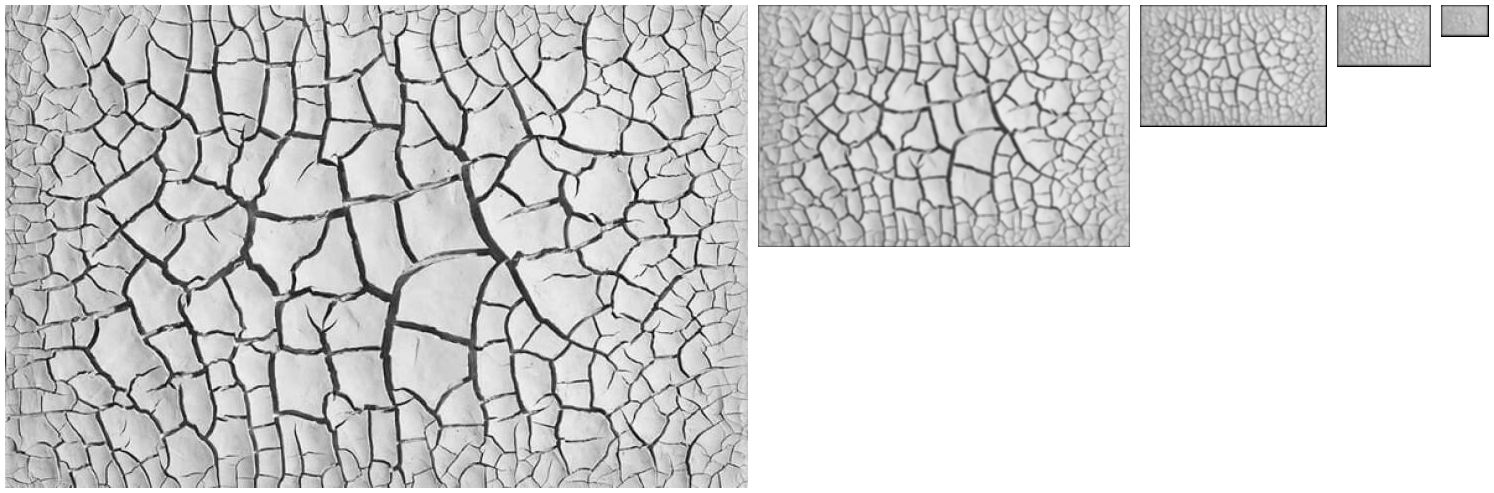

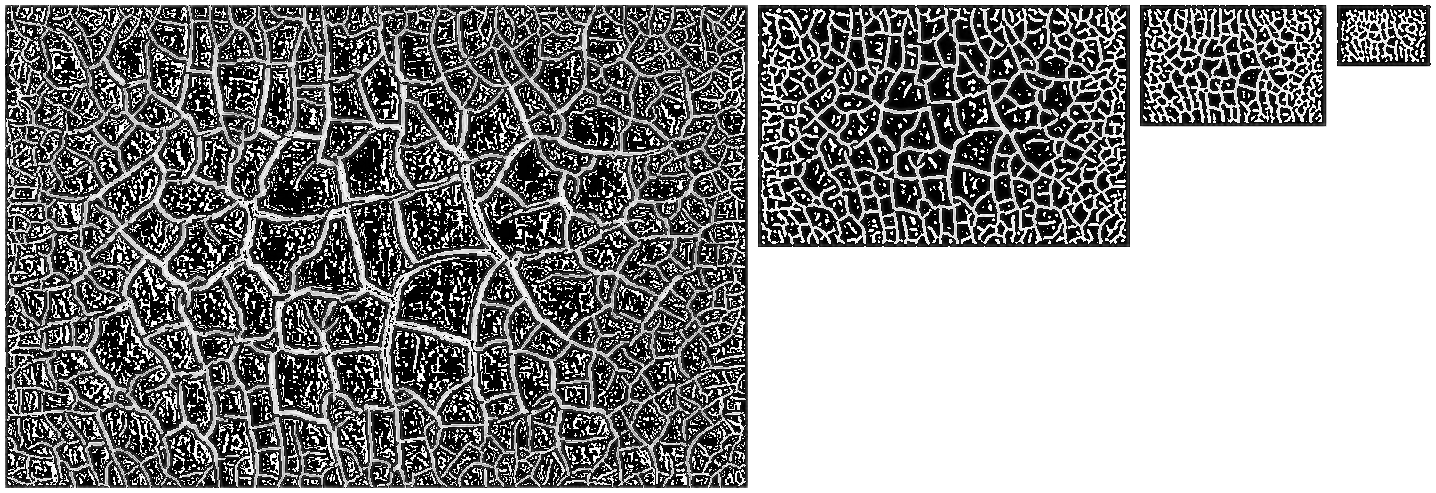

In [7]:
border_size = 5

# Gaussian Pyramid Visualization
total_width_gauss = sum(image.width + 2*border_size for image in gauss_pyramid)
row_image_gauss = Image.new('RGB', (total_width_gauss, 483 + 2*border_size), (256, 256, 256))

x_offset = 0
for image in gauss_pyramid:
    row_image_gauss.paste(image, (x_offset + border_size, border_size))
    x_offset += image.width + 2*border_size

display(row_image_gauss)

# Laplacian Pyramid Visualization
total_width_laplace = sum(image.width + 2*border_size for image in laplace_pyramid) # Should be the same
row_image_laplace = Image.new('RGB', (total_width_laplace, 483 + 2*border_size), (256, 256, 256))

x_offset = 0
for image in laplace_pyramid:
    row_image_laplace.paste(image, (x_offset + border_size, border_size))
    x_offset += image.width + 2*border_size

display(row_image_laplace)

**Problem 1, Part 2 - FFT Amplitudes of the Image Pyramids**

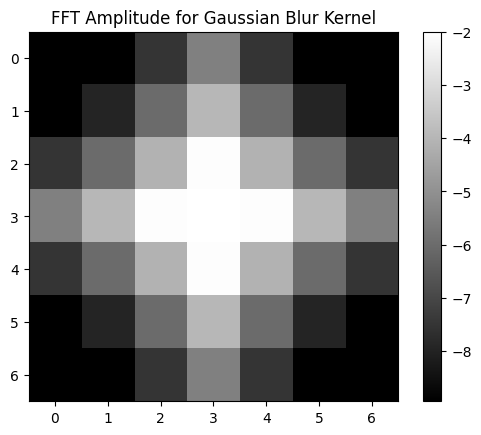

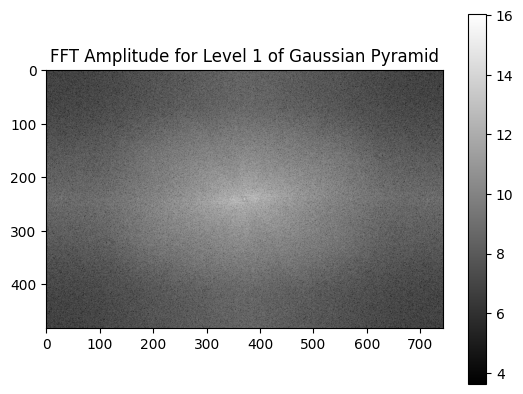

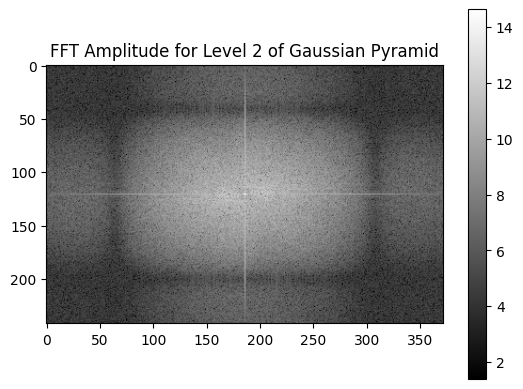

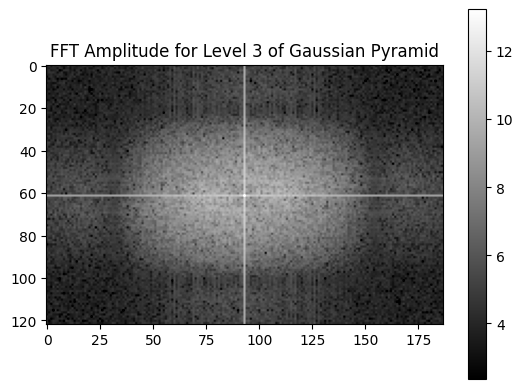

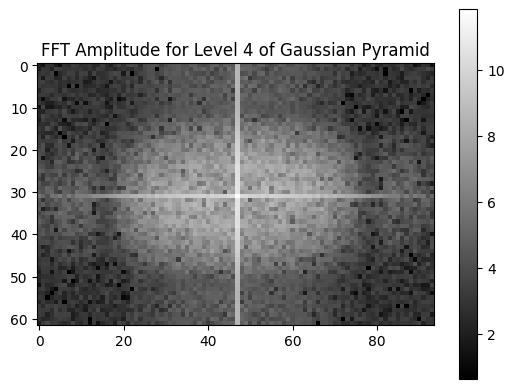

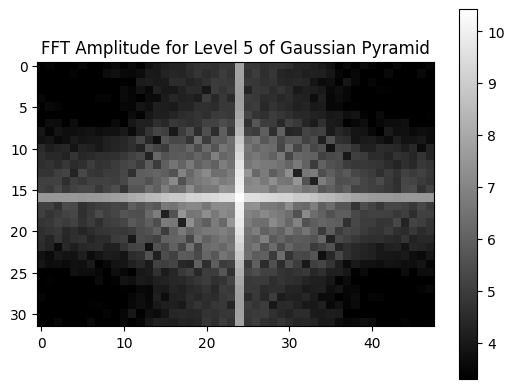

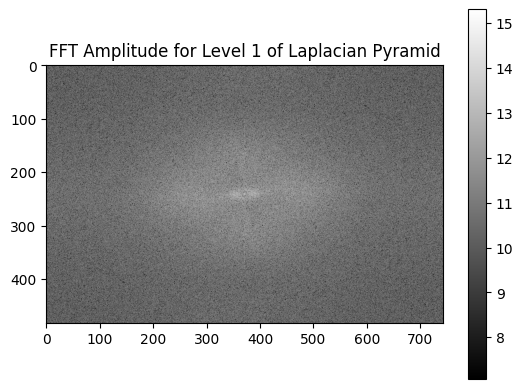

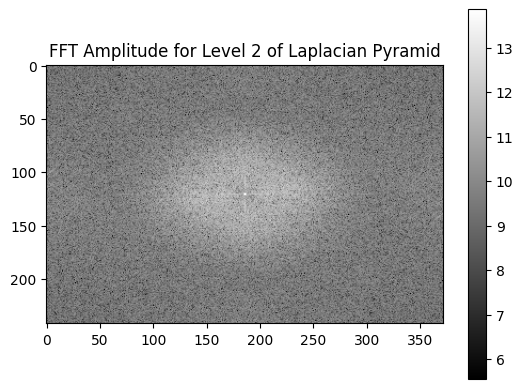

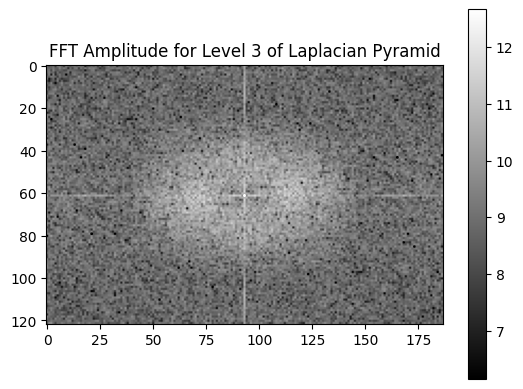

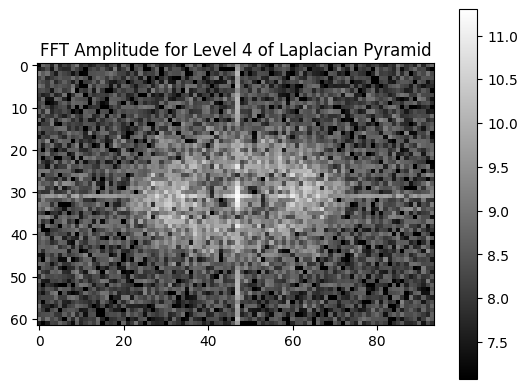

In [8]:
def display_fft_amplitude(image, plot_title):
  # Compute the Fourier Transform
  f = np.fft.fft2(image)
  fshift = np.fft.fftshift(f)
  magnitude_spectrum = np.log(np.abs(fshift))

  plt.imshow(magnitude_spectrum, cmap='gray', vmin=np.min(magnitude_spectrum + 2), vmax=np.max(magnitude_spectrum - 2))
  plt.title("FFT Amplitude " + plot_title)
  plt.colorbar()
  plt.show()

# Sanity Check on my Gaussian Kernel to make sure FFT Amplitudes look correct
img_np = np.array(g)
title = "for Gaussian Blur Kernel"
display_fft_amplitude(img_np, title)

for i, level in enumerate(gauss_pyramid):
  title = "for Level "
  title += str(i+1)
  title += " of Gaussian Pyramid"
  img_np = np.array(level)
  display_fft_amplitude(img_np, title)

for i, level in enumerate(laplace_pyramid):
  title = "for Level "
  title += str(i+1)
  title += " of Laplacian Pyramid"
  img_np = np.array(level)
  display_fft_amplitude(img_np, title)

In [ ]:
# In terms of frequency, the Gaussian pyramids perform smoothing, acting as a low pass filter, filtering out high frequency details from the
# image, through a slight blur, which allows us to downsize the image without as much perceived loss in quality. The Laplacian filters, on the
# other hand, behave as a band pass filter, capturing the frequencies that are lost at each level of the Gaussian pyramid,
# focusing on the high-frequency details of the image.

**Problem 2: Edge Detection**

**Problem 2, Part 1 - Gradient Based Edge Detector using Sobel Filters**

In [9]:
def gradient_magnitude(img, sigma):

  GLOBAL_KERNEL_SIZE = 5

  # Preprocess the image, seperate into channels, just in case bad format
  img_np = np.array(img)

  # Create the Gaussian filter for smoothing, Define the Sobel Kernels
  gauss_filter = gauss_kernel(GLOBAL_KERNEL_SIZE, sigma)
  x_sobel = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
  y_sobel = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])

  # Convolve - my convolve function doesn't work for 3d images here :(
  # smoothed = convolution(img_np, gauss_filter)
  # x_gradient = convolution(smoothed, x_sobel)
  # y_gradient = convolution(smoothed, y_sobel)

  smoothed = cv2.filter2D(img_np, -1, gauss_filter)
  x_gradient = cv2.filter2D(smoothed, -1, x_sobel)
  y_gradient = cv2.filter2D(smoothed, -1, y_sobel)

  # Seperate into channels
  rx = x_gradient[:, :, 0]
  ry = y_gradient[:, :, 0]

  gx = x_gradient[:, :, 1]
  gy = y_gradient[:, :, 1]

  bx = x_gradient[:, :, 2]
  by = y_gradient[:, :, 2]

  # Compute x_gradient using L2 norm of RGB channels
  x_gradient_l2 = np.sqrt(np.sum(x_gradient**2, axis=2))
  y_gradient_l2 = np.sqrt(np.sum(y_gradient**2, axis=2))

  # Compute gradient magnitude
  gradient_mag = np.sqrt(x_gradient_l2**2 + y_gradient_l2**2)

  # Now to compute the angle, find which channel has the greatest magnitude, then take the angle of that color
  r_mag = np.sqrt(rx**2 + ry**2)
  r_angles = np.arctan2(ry, rx)

  g_mag = np.sqrt(gx**2 + gy**2)
  g_angles = np.arctan2(gy, gx)

  b_mag = np.sqrt(bx**2 + by**2)
  b_angles = np.arctan2(by, bx)

  gradient_angles = np.zeros_like(r_angles)

  for i in range(r_angles.shape[0]):
    for j in range(r_angles.shape[1]):
      max_mag = max(r_mag[i, j], g_mag[i, j], b_mag[i, j])
      if max_mag == r_mag[i, j]:
        gradient_angles[i, j] = r_angles[i, j]
      elif max_mag == g_mag[i, j]:
        gradient_angles[i, j] = g_angles[i, j]
      else:
        gradient_angles[i, j] = b_angles[i, j]

  return gradient_mag, gradient_angles

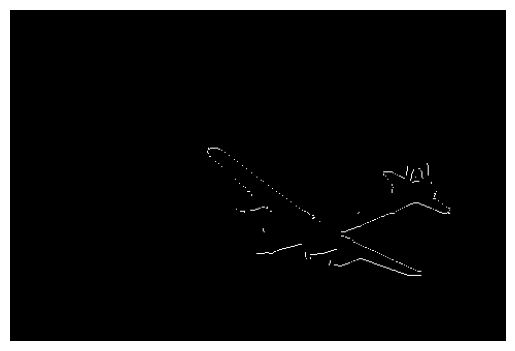

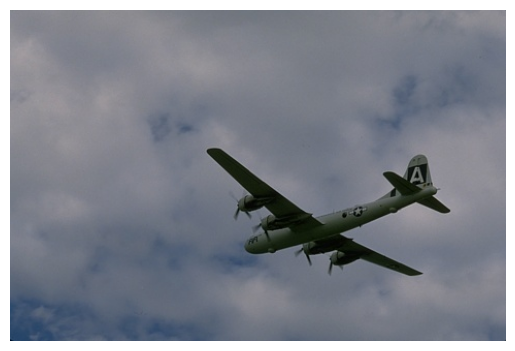

In [10]:
# Use the gradient magnitude function to find edges and display them
def edge_gradient(img):
  gradient_mag, gradient_angle = gradient_magnitude(img_np_float, 2)
  cleaned_up = non_max_suppression(gradient_mag, gradient_angle)

  plt.imshow(cleaned_up, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.imshow(img_np)
  plt.axis('off')
  plt.show()

# Run edge gradient function with input image array
img = Image.open(plane_path)
img_np = np.array(img)
img_np_float = img_np.astype(np.float32) / 255.0

edge_gradient(img_np_float)

**Problem 2, Part 2 - Oriented Filter Edge Detection using Gabor Filters**

In [55]:
# Choice of Filters Writeup:
# We were told to use a set of "oriented" filters which implies that we want some sort of filter that can (a) be used in
# multiple orientations (I'll visualize this as angles) and (b) one that has good edge detection properties irregardless of orientation.
# I chose Gabor as it utilizes a kernel calculated with highly tunable parameters (also simple to calculate and code up),
# and a theta variable which allows me to easily customize my orientation. Furthermore, the Gabor filter can be highly
# tuned for edge detectiondue to its structure, being a filter created by overlaying a Gaussian filter on to a sinusoid.
# https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97 for the visualization of the creation of the Gabor filter
# https://en.wikipedia.org/wiki/Gabor_filter for the formula for calculating the kernel

# Helper Function to create the Gabor Filter Kernel

def gabor_kernel(size, sigma, theta, lam, gamma, psi):
  # sigma: Standard deviation of the Gaussian envelope.
  # theta: Orientation of the filter in radians (0 is horizontal).
  # lam: Wavelength of the sinusoidal factor.
  # gamma: Spatial aspect ratio.
  # psi: Phase offset.

  gabor = np.zeros((size, size), dtype=np.float32)

  for x in range(size):
      for y in range(size):
          x_prime = (x - size // 2) * np.cos(theta) + (y - size // 2) * np.sin(theta)
          y_prime = -(x - size // 2) * np.sin(theta) + (y - size // 2) * np.cos(theta)
          exp_part = np.exp(-(x_prime**2 + gamma**2 * y_prime**2) / (2 * sigma**2))
          cos_part = np.cos(2 * np.pi * x_prime / lam + psi)
          gabor[x, y] = exp_part * cos_part

  return gabor

# Application helper function because we can have 4+ orientations
def apply_gabor_filters(img, kernels):

  magnitudes = []
  orientations = []

  # Apply each kernel and stack resulting arrays
  for kernel in kernels:
    result = cv2.filter2D(img, cv2.CV_32F, kernel)
    magnitudes.append(np.square(result))
    orientations.append(np.arctan2(np.imag(result), np.real(result)))

  total_magnitude = np.sqrt(sum(magnitudes))

  max_orientation = np.argmax(magnitudes, axis=0)
  final_orientation = np.take_along_axis(np.array(orientations), np.expand_dims(max_orientation, axis=0), axis=0)[0]

  return total_magnitude, final_orientation

In [59]:
def oriented_filter_magnitude(img):
  img_float32 = np.float32(img) / 255.0

  # GABOR KERNEL PARAMS
  GLOBAL_GABOR_THRESHOLD = 0.048
  theta = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
  lam = 10.0
  sigma = 4.0
  gamma = 0.5
  psi = 0

  kernels = [gabor_kernel(21, sigma, th, lam, gamma, psi) for th in theta]

  combined_magnitude = None
  combined_orientation = None

  # For each color channel
  for channel in range(3):
    channel_img = img_float32[:, :, channel]
    magnitude, orientation = apply_gabor_filters(channel_img, kernels)

    # Combine magnitudes and orientations from all channels
    if combined_magnitude is None:
      combined_magnitude = magnitude
      combined_orientation = orientation
    else:
      combined_magnitude = np.maximum(combined_magnitude, magnitude)
      combined_orientation = np.where(magnitude > combined_magnitude, orientation, combined_orientation)

  # thresholded = np.where(combined_magnitude > GLOBAL_GABOR_THRESHOLD, 1, 0)
  thresholded = combined_magnitude

  # Visualize kernels
  print("Visualization of the Gabor Filters Used:")
  for kernel in kernels:
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')
    plt.show()

  return thresholded, combined_orientation

Visualization of the Gabor Filters Used:


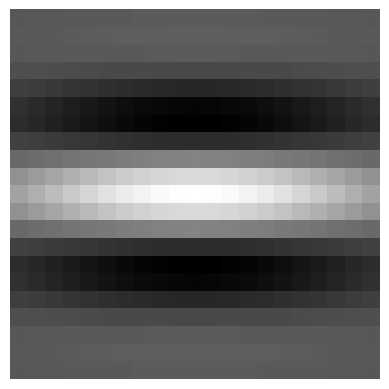

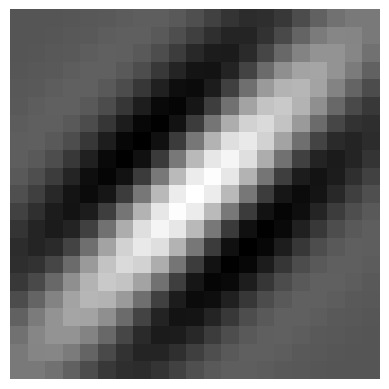

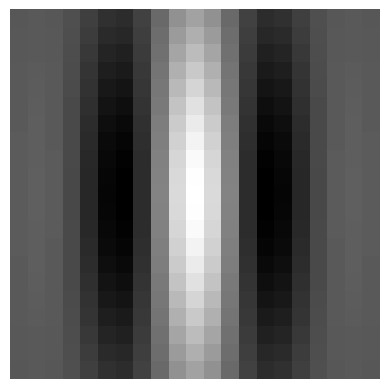

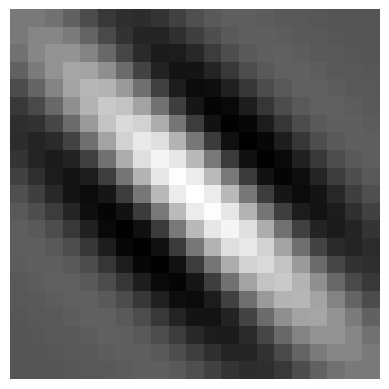

Edges Detected and Original Image Below: 


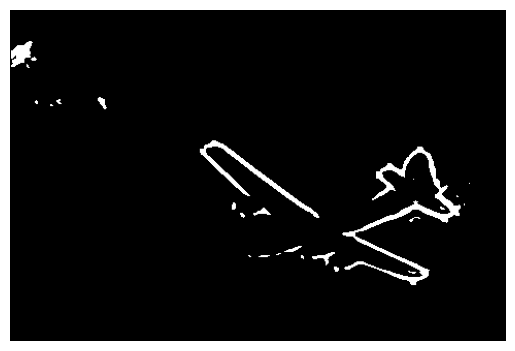

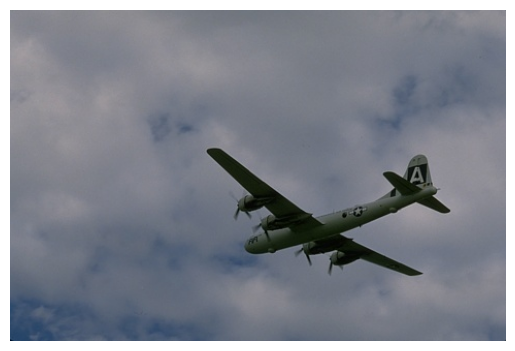

In [57]:
# Use the gradient magnitude function to find edges and display them

def edge_oriented_filters(img):
  # Just in case bad formatting
  img_np = np.array(img)
  img_np_float = img_np.astype(np.float32) / 255.0

  oriented_mag, oriented_angles = oriented_filter_magnitude(img_np_float)
  cleaned_up = non_max_suppression(oriented_mag, oriented_angles)
  print("Edges Detected and Original Image Below: ")
  plt.imshow(cleaned_up, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.imshow(img_np)
  plt.axis('off')
  plt.show()

img = Image.open(plane_path)
img_np = np.array(img)
edge_oriented_filters(img_np)

In [ ]:
# Compared to the edges in part 1, I was successfully able with the Gabor filters to clearly define the diagonal
# borders of the plane wings and the rounded border of the tail of the plane. They excel in edge detection due to their orientation sensitivity
# and ability to capture specific frequencies and scales, which we were able to fine tune with the sinusoid parameters.
# There was a little failure on more obscure edges like the spinning fans at the front, but this was also a struggle as their
# performance is limited by the set of orientations useds of spinning plane fans.

**Problem 2, Part 3**

The most obvious point of improvement I would look towards is a solution for thresholding. In my solution, I used a very naive implementation of thresholding to get rid of the noise, particularly caused by the plane details and the clouds. However, in this image, we can see clearly issues in this. The view of the plane is from the bottom, which causes a darkening on the subject, while the rest of the image has some dimness added to it, which can add difficulty in noticing subtle edges. Already, from the human viewpoint, we're missing all of the main cloud edges.

From there, I took a look at a paper which popped up pretty soon after looking up Gabor filtering methods, when I was working on part 2.2, linked below. This paper is cool primarily because it uses the method I used, Gabor filters, and avoided using Canny edge detection which made it more relevant to my purposes.

They discuss in part of the paper a method called variable thresholding, which unlike my approach, adjusts the threshold based on the local characteristics of different image regions. Rather than using Gabor filters entirely for edge detection, we can rather use those and blurring filters to reduce noise, then apply non-maxima suppresion like in the lab. From there, once we have a cleaned up image, we can then adjust our thresholding based on neighboring values, to identify the difference between soft, strong, and medium edges, as opposed to just edges and non edges.

This difference was seen clearly in this lab, in my resulting image prior to using thresholding. I could clearly make out edges as drawn by the algorithm, but the noise of the image remained. Once I removed noise using a fixed threshold, edges were also lost.

To accomplish this, I would try the following:

- Create 4 different versions of the image along 4 orientations using Gabor filters
- Identify the maximum magnitude at each point then use that for the finalized edges, and to avoid blurring out edges
- Utilize a histogram to determine the distribution of pixel intensity in the image
- Utilize a small (3x3 - 5x5) kernel to compute the average pixel intensity of a region. If the distribution of this region is greater than that of the overall image, increase the threshold, and vice versa, decrease if it's less than the overall image
- Black and White out pixels accordingly, maintaining both soft and strong edges.


https://aircconline.com/sipij/V13N5/13522sipij01.pdf